# Project 2: Ames Iowa Home Price Predictions

In [1]:
import pandas as pd
import numpy as np
import os

### Data Cleaning

In [2]:
raw_unedited_copy = pd.read_csv('../datasets/train.csv')
raw_data = pd.read_csv('../datasets/train.csv')
raw_data.columns = raw_data.columns.str.replace(' ', '_').str.lower()
raw_data.shape[0]

2051

In [3]:
metadata = pd.read_csv('../datasets/ames_metadata.csv', index_col=0)
metadata = metadata.assign(ord_transform_map = None)

- Creating a simple dataframe that runs through all of the columns in the data, which will then be manually classified as \
Nom / Ord / numerical data

- This will be used to reference specific types of variables, which will be very helpful for null_handling and broader organization

In [4]:
def get_variable_type(df, col):
    # Get the variable type of the specified column
    variable_type = metadata.loc[metadata['column_name'] == col, 'variable_type'].iloc[0]
    return variable_type

In [5]:
def check_nulls(df):
    '''
    returns full dict with null counts
    as well as a dict with only null counts greater than zero
    '''
    all_cols = {}
    for col in df.columns:
        all_cols[col] = df[col].isnull().sum()
    
    not_zero = {}
    for key, val in all_cols.items():
        if val > 0:
            not_zero[key] = val
        
    return all_cols, not_zero

In [6]:
null_dict = check_nulls(raw_data)[1]

In [7]:
cols_w_nulls = check_nulls(raw_data)[1].keys()

___________
#### Checking Value of Using most null Columns

In [8]:
raw_data.loc[:,[x for x in cols_w_nulls if null_dict[x] >= 150]]['pool_qc']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
2046    NaN
2047    NaN
2048    NaN
2049    NaN
2050    NaN
Name: pool_qc, Length: 2051, dtype: object

### Handling of Variable types Notes

- As shown below. All variables in this model have been manually labeled
- See below for summary statistics of the variable types

In [9]:
metadata['variable_type'].unique()

array(['Nominal', 'Numerical', 'Ordinal', 'Binary', 'Target'],
      dtype=object)

In [10]:
metadata.groupby('variable_type').describe()

is_unique                                          is_target  \
                  count  mean       std  min  25%  50%  75%  max     count   
variable_type                                                                
Binary              1.0  0.00       NaN  0.0  0.0  0.0  0.0  0.0       1.0   
Nominal            25.0  0.08  0.276887  0.0  0.0  0.0  0.0  1.0      25.0   
Numerical          29.0  0.00  0.000000  0.0  0.0  0.0  0.0  0.0      29.0   
Ordinal            25.0  0.00  0.000000  0.0  0.0  0.0  0.0  0.0      25.0   
Target              1.0  0.00       NaN  0.0  0.0  0.0  0.0  0.0       1.0   

                                                  
              mean  std  min  25%  50%  75%  max  
variable_type                                     
Binary         0.0  NaN  0.0  0.0  0.0  0.0  0.0  
Nominal        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
Numerical      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
Ordinal        0.0  0.0  0.0  0.0  0.0  0.0  0.0  
Target         1.0  NaN  1.0  1.0  1.0  1.0  1.0

In [11]:
cleaned_data = raw_data

### Null Handling Notes

### Data Eliminations

#### Pool Columns

In [12]:
cleaned_data[cleaned_data['pool_area'] == 0].shape[0]

2042

- 2042 homes in this area do not have pools. will be dropping the two corresponding columns

In [13]:
cleaned_data = cleaned_data.drop(columns = ['pool_qc','pool_area'])

___________

#### Alley

- Alley access is very infrequently a feature of single-family housing. It shouldn't be taken seriously as a value-driving variable

In [14]:
cleaned_data = cleaned_data.drop(columns = ['alley'])

___________

#### Fence

- Fensing is really very inexpensive in comparison to a house. From my background in the industry it truely doesn't belong here

In [15]:
cleaned_data = cleaned_data.drop(columns = ['fence'])

__________

#### Garage Columns

In [16]:
cleaned_data['garage_qual'].describe()

count     1937
unique       5
top         TA
freq      1832
Name: garage_qual, dtype: object

- Garage appears to not vary in quality, will drop this column

In [17]:
cleaned_data = cleaned_data.drop(columns = ['garage_qual'])

_________________

#### Masonry veneer type

In [18]:
cleaned_data['mas_vnr_type'].describe()

count     2029
unique       4
top       None
freq      1218
Name: mas_vnr_type, dtype: object

- Veneer type is most often a none. Doesn't appear to be a major value driver either. Will drop from model

In [19]:
cleaned_data = cleaned_data.drop(columns = ['mas_vnr_type'])

__________

[Placeholder]: going to ignore misc feature for now, may incorporate later in more complicated model

In [20]:
cleaned_data = cleaned_data.drop(columns = ['misc_feature'])

_______

### Ordinal Variables Transformations: Not exactly 'nulls'-per se

 - According to the data dictionary provided by kaggle, the NA's in these cases are less nulls, and should be interpreted as 'not applicable.' in the following ordinal cases, will translate ordinal value-drivers as described above

In [21]:
popular_ord_transform = {'Ex' : 5,  'Gd' : 4, 'TA' : 3, 'Fa': 2, 'Po' : 1, np.nan: 0} 
#will be useded multiple times for transformations

garage_finish_dict = {'Fin':3,'RFn': 2, 'Unf':1, np.nan: 0}
basement_finish_dict = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1, np.nan:0}
basement_exp_dict = {'Gd':3,'Av':2,'Mn':1, 'No':0, np.nan:0}
#treating having no basement exposure as the same as no basement at all WRT this particular variable

In [22]:
def ord_transform(df, col, transform):
    assert transform
    df[col] = [transform[x] for x in df[col]]
    metadata.loc[metadata['column_name'] == col, 'ord_transform_map'] = str(transform)
    return df

In [23]:
null_group =  check_nulls(cleaned_data)[1].keys()

________

#### Fireplace

In [24]:
cleaned_data = ord_transform(cleaned_data,'fireplace_qu',popular_ord_transform)

#### Basement

In [25]:
cleaned_data = ord_transform(cleaned_data,'bsmt_qual',popular_ord_transform)

In [26]:
cleaned_data = ord_transform(cleaned_data,'bsmt_cond',popular_ord_transform)

In [27]:
cleaned_data = ord_transform(cleaned_data,'bsmtfin_type_1',basement_finish_dict)

In [28]:
cleaned_data = ord_transform(cleaned_data,'bsmt_exposure',basement_exp_dict)

- Note for reader:, bsmt_exposure is Walkout or garden level basement wall exposure to outside
- Dict Definition of BsmtExposure: Walkout or garden level basement walls, so Personally I'm thinking that the impact of no basement at all would be the same of no exposure, so treating the nans as the same as no exposure

#### Garage

In [29]:
cleaned_data = ord_transform(cleaned_data,'garage_finish',garage_finish_dict)

In [30]:
cleaned_data = ord_transform(cleaned_data,'garage_cond',popular_ord_transform)

____________

### Null Imputation Categories

In [31]:
impute_median = set()
impute_mean = set()
impute_mode = set()

In [32]:
def nulls_to_be_handled(df):
    output = set()
    for column, null_count in check_nulls(df)[1].items():
        if column not in impute_median and column not in impute_mean and column not in impute_mode:
            output.add((column,get_variable_type(df,column)))
    return output

#### Numerical Data

#### Lot Frontage

In [33]:
cleaned_data['lot_frontage'].describe()

count    1721.000000
mean       69.055200
std        23.260653
min        21.000000
25%        58.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: lot_frontage, dtype: float64

- due to outliers on right end will impute on median 

In [34]:
impute_median.add('lot_frontage')

#### Masonry Veneer Area

In [35]:
cleaned_data['mas_vnr_area'].describe()

count    2029.000000
mean       99.695909
std       174.963129
min         0.000000
25%         0.000000
50%         0.000000
75%       161.000000
max      1600.000000
Name: mas_vnr_area, dtype: float64

In [36]:
cleaned_data['mas_vnr_area'].mode()

0    0.0
Name: mas_vnr_area, dtype: float64

In [37]:
impute_median.add('mas_vnr_area')

- Big right scew so will impute the median / also the mode

#### Basement Numerical 

In [38]:
basement_numerical = ['bsmt_full_bath','bsmt_half_bath','bsmt_unf_sf','bsmtfin_sf_1','bsmtfin_sf_2','total_bsmt_sf']

- First will set all values where we know that there is no basement, will set all datapoints to zero

In [39]:
basement_null_df = cleaned_data[basement_numerical].isnull().sum()

In [40]:
cleaned_data.bsmt_full_bath.describe()

count    2049.000000
mean        0.427526
std         0.522673
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: bsmt_full_bath, dtype: float64

In [41]:
cleaned_data.bsmt_full_bath.mode()

0    0.0
Name: bsmt_full_bath, dtype: float64

- Will impute the median, as the median and mode are both zero and are most frequnt.
- Imputing the mean appears less interpretable to me

In [42]:
impute_median.add('bsmt_full_bath')

In [43]:
cleaned_data.bsmt_half_bath.describe()

count    2049.000000
mean        0.063446
std         0.251705
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: bsmt_half_bath, dtype: float64

In [44]:
impute_median.add('bsmt_half_bath')

- Similarly will do the same for half bath

In [45]:
cleaned_data.bsmt_unf_sf.describe()

count    2050.000000
mean      567.728293
std       444.954786
min         0.000000
25%       220.000000
50%       474.500000
75%       811.000000
max      2336.000000
Name: bsmt_unf_sf, dtype: float64

- Right scew so median

In [46]:
impute_median.add('bsmt_unf_sf')

In [47]:
cleaned_data.bsmtfin_sf_1.describe()

count    2050.000000
mean      442.300488
std       461.204124
min         0.000000
25%         0.000000
50%       368.000000
75%       733.750000
max      5644.000000
Name: bsmtfin_sf_1, dtype: float64

- Similarly scewed distribution, so will imput medianbsmtfin_sf_2

In [48]:
impute_median.add('bsmtfin_sf_1')

In [49]:
cleaned_data.bsmtfin_sf_2.describe()

count    2050.000000
mean       47.959024
std       165.000901
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: bsmtfin_sf_2, dtype: float64

- Similarly scewed distribution, so will imput median

In [50]:
impute_median.add('bsmtfin_sf_2')

In [51]:
cleaned_data.total_bsmt_sf.describe()

count    2050.000000
mean     1057.987805
std       449.410704
min         0.000000
25%       793.000000
50%       994.500000
75%      1318.750000
max      6110.000000
Name: total_bsmt_sf, dtype: float64

- Skewed dist so will impute median

In [52]:
impute_median.add('total_bsmt_sf')

In [53]:
nulls_to_be_handled(cleaned_data)

{('bsmtfin_type_2', 'Nominal'),
 ('garage_area', 'Numerical'),
 ('garage_cars', 'Numerical'),
 ('garage_type', 'Nominal'),
 ('garage_yr_blt', 'Numerical')}

#### Garage Numerical 

In [54]:
cleaned_data.garage_area.describe()

count    2050.000000
mean      473.671707
std       215.934561
min         0.000000
25%       319.000000
50%       480.000000
75%       576.000000
max      1418.000000
Name: garage_area, dtype: float64

- Mean is sitting under the median here, despite high outliers. Thinking that this should impute the mean

In [55]:
impute_mean.add('garage_area')

In [56]:
cleaned_data.garage_cars.describe()

count    2050.000000
mean        1.776585
std         0.764537
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: garage_cars, dtype: float64

In [57]:
cleaned_data.garage_cars.mode()

0    2.0
Name: garage_cars, dtype: float64

- Mode is matching the median here at 2. Considering that you can't have 1.77 cars in a garage, imputing median here appears to make more sense intuitively 

In [58]:
impute_median.add('garage_cars')

In [59]:
cleaned_data.garage_yr_blt.describe()

count    1937.000000
mean     1978.707796
std        25.441094
min      1895.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2207.000000
Name: garage_yr_blt, dtype: float64

- Noticed that there's at least one incorrect data point with that max

In [60]:
cleaned_data.shape[0]

2051

In [61]:
cleaned_data.garage_yr_blt = [cleaned_data.garage_yr_blt.median() if x > 2022 else x for x in cleaned_data.garage_yr_blt]

- Replacing the garage year built to the mean of the column if it is greater than 2022. Probably not worth removing ~100 rows over this issue
- Will impute median for null values

In [62]:
impute_median.add('garage_yr_blt')

### Nominal Null Handling

- Will impute with the mode, as 'Unf' is all but ~200 of the values in this column

In [63]:
cleaned_data.bsmtfin_type_2.isnull().sum()

56

In [64]:
impute_mode.add('bsmtfin_type_2')

In [65]:
cleaned_data.garage_type.describe()

count       1938
unique         6
top       Attchd
freq        1213
Name: garage_type, dtype: object

- Will impute with mode, as its the dominant factor here

In [66]:
impute_mode.add('garage_type')

In [67]:
cleaned_data = cleaned_data.reset_index(drop=True)

In [68]:
cleaned_data.to_csv(('../datasets/train-cleaned.csv'))

#### Metadata_cleaned csv file where it only includes the column_name's that will be in the Model

In [69]:
metadata_cleaned = metadata

In [70]:
metadata_cleaned = metadata_cleaned[metadata_cleaned.column_name.isin(x for x in cleaned_data.columns)]

#### Saving Imputation Decisions in Metadata file:

In [71]:
i_mean =  [1 if x in impute_mean else 0 for x in metadata_cleaned.column_name ]

In [72]:
metadata_cleaned = metadata_cleaned.assign(impute_mean=i_mean) 

In [73]:
i_median = [1 if x in impute_median else 0 for x in metadata_cleaned.column_name ]

In [74]:
metadata_cleaned = metadata_cleaned.assign(impute_median=i_median) 

In [75]:
i_mode = [1 if x in impute_mode else 0 for x in metadata_cleaned.column_name]

In [76]:
metadata_cleaned = metadata_cleaned.assign(impute_mode=i_mode) 

In [77]:
metadata_cleaned.to_csv('../datasets/metadata-cleaned.csv') #Save down file

## Exploratory Analysis

In [78]:
cleaned_data.saleprice

0       130500
1       220000
2       109000
3       174000
4       138500
         ...  
2046    298751
2047     82500
2048    177000
2049    144000
2050    189000
Name: saleprice, Length: 2051, dtype: int64

Text(0.5, 1.0, 'Histogram of Ames Iowa SF RE Sales Prices')

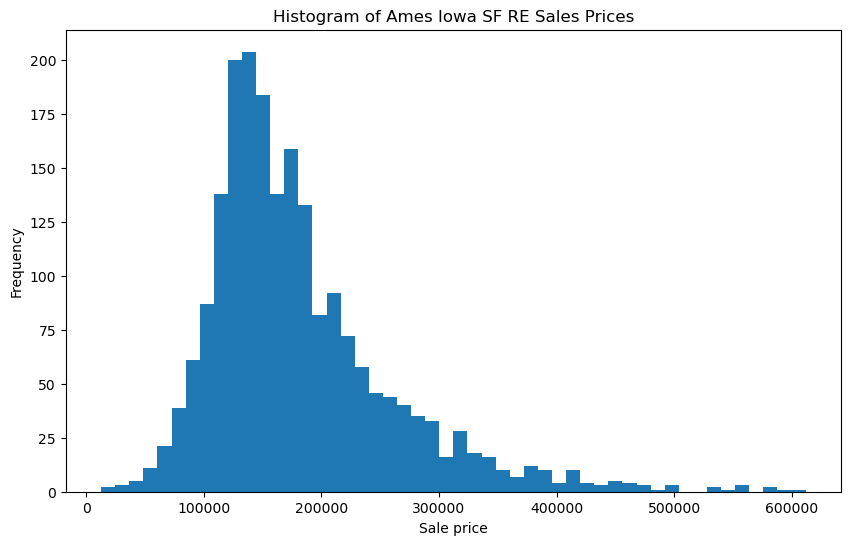

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Plot the histogram
plt.hist(cleaned_data.saleprice, bins=50)

# Add axis labels and a title
plt.xlabel('Sale price')
plt.ylabel('Frequency')
plt.title('Histogram of Ames Iowa SF RE Sales Prices')

- Clear right skew

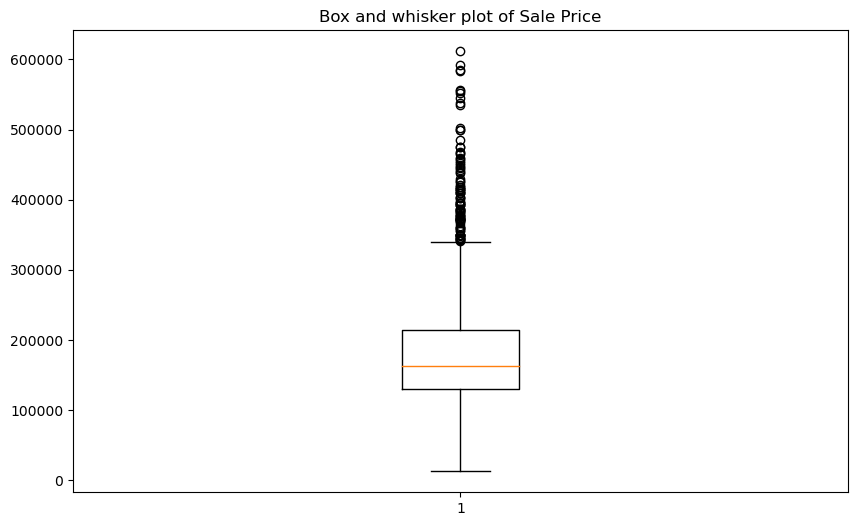

In [82]:
plt.figure(figsize=(10, 6))
plt.boxplot(cleaned_data.saleprice)
plt.title('Box and whisker plot of Sale Price')
plt.xlabel('')
plt.show()

- Something that I learned through going through this experience is that I could have considered some elements\
to differentiate between the big outliers on the high-end, and normal homes